!pip install --upgrade xgboost matplotlib pandas scikit-learn mplfinance

# NBeats first version

Final train label distribution:
 label
0    668
1    121
Name: count, dtype: int64
Final test label distribution:
 label
0    157
1     41
Name: count, dtype: int64


/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[157   0]
 [ 40   1]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       157
           1       1.00      0.02      0.05        41

    accuracy                           0.80       198
   macro avg       0.90      0.51      0.47       198
weighted avg       0.84      0.80      0.71       198



/var/folders/jf/bv5tm1xj0gl2z7_bb3q05rgm0000gn/T/ipykernel_68319/2439248274.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["predicted"] = y_pred
/var/folders/jf/bv5tm1xj0gl2z7_bb3q05rgm0000gn/T/ipykernel_68319/2439248274.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["actual"] = y_test


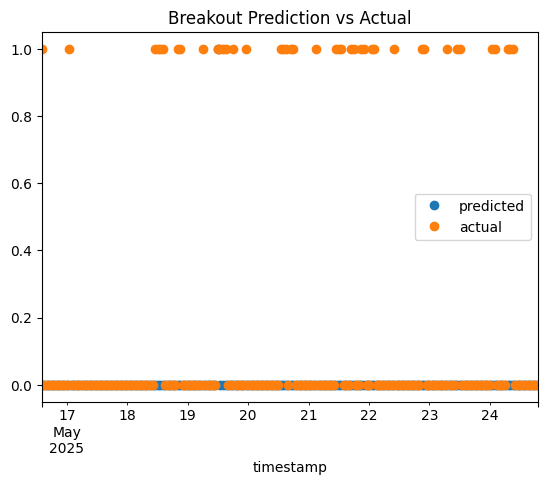

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import requests
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 2. Fetch OHLCV data from Binance
url = "https://api.binance.com/api/v3/uiKlines"
params = {
    "symbol": "BTCUSDC",
    "interval": "1h",
    "limit": 1000
}
response = requests.get(url, params=params)
data = response.json()

# 3. Format Binance data into DataFrame
df = pd.DataFrame(data, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "_", "_", "_", "_", "_", "_"
])
df = df[["timestamp", "open", "high", "low", "close", "volume"]]
df = df.astype({"open": float, "high": float, "low": float, "close": float, "volume": float})
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
df.set_index("timestamp", inplace=True)

# 4. Technical Indicators (Manual ATR and RSI)
def calculate_atr(df, period=14):
    high_low = df["high"] - df["low"]
    high_close = np.abs(df["high"] - df["close"].shift())
    low_close = np.abs(df["low"] - df["close"].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def calculate_rsi(df, period=14):
    delta = df["close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# 5. Feature Engineering
df["ATR14"] = calculate_atr(df)
df["RSI14"] = calculate_rsi(df)
df["candle_body_pct"] = (df["close"] - df["open"]) / df["open"]
df["candle_wick_top"] = df["high"] - df[["open", "close"]].max(axis=1)
df["candle_wick_bottom"] = df[["open", "close"]].min(axis=1) - df["low"]

# 6. Labeling Breakouts
future_returns = df["close"].shift(-2) / df["close"] - 1
df["label"] = 0
df.loc[future_returns > 0.005, "label"] = 1

# 7. Prepare data
features = [
    "open", "high", "low", "close", "volume",
    "ATR14", "RSI14", "candle_body_pct", "candle_wick_top", "candle_wick_bottom"
]
df = df.dropna()
X = df[features]
y = df["label"]

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 9. Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 10. Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 11. Plot predictions
X_test["predicted"] = y_pred
X_test["actual"] = y_test
X_test[["predicted", "actual"]].plot(style='o', title="Breakout Prediction vs Actual")
plt.show()

# Second version with probabilities (confidence) adjustments

X_train                      candle_body_pct  candle_wick_top  candle_wick_bottom  \
open_time                                                                   
2025-04-13 19:00:00        -0.442347             0.00              932.63   
2025-04-13 20:00:00        -0.379759           452.86              336.00   
2025-04-13 21:00:00         0.121195           217.90              464.22   
2025-04-13 22:00:00        -0.382204           271.68              162.05   
2025-04-13 23:00:00         0.630598            84.25              165.99   
...                              ...              ...                 ...   
2025-05-16 08:00:00        -0.468756            60.40              285.95   
2025-05-16 09:00:00         0.962331            16.05                0.00   
2025-05-16 10:00:00         0.038882            70.66              175.79   
2025-05-16 11:00:00        -0.401722           105.99              102.51   
2025-05-16 12:00:00        -0.565800           111.52               

/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


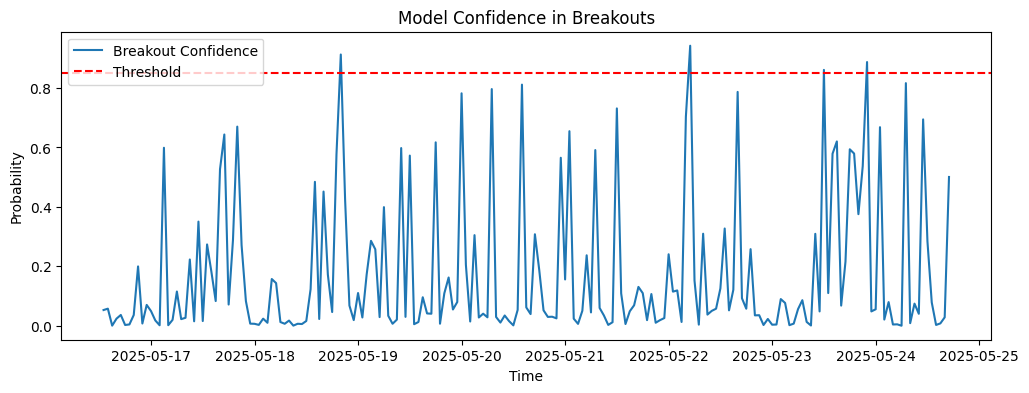


Top breakout hints:
                     candle_body_pct  candle_wick_top  candle_wick_bottom  \
open_time                                                                   
2025-05-22 05:00:00        -0.734119           180.42               41.92   
2025-05-18 20:00:00         0.197599           175.86              603.52   
2025-05-23 22:00:00        -0.527260           283.00              162.60   
2025-05-23 12:00:00        -0.351441            30.46             1127.03   

                     volatility        ATR14  breakout_prob  \
open_time                                                     
2025-05-22 05:00:00    0.009079  1295.272143       0.941995   
2025-05-18 20:00:00    0.004357   628.284286       0.912452   
2025-05-23 22:00:00    0.006596   985.979286       0.887121   
2025-05-23 12:00:00    0.005505   676.095000       0.860712   

                     predicted_breakout  true_label  
open_time                                            
2025-05-22 05:00:00          

In [ ]:
# 1. Imports
import pandas as pd
import requests
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 2. Fetch OHLCV data from Binance
url = "https://api.binance.com/api/v3/uiKlines"
params = {
    "symbol": "BTCUSDC",
    "interval": "1h",
    "limit": 1000
}
response = requests.get(url, params=params)
data = response.json()


# --- 2. Convert to DataFrame ---
df = pd.DataFrame(data, columns=[
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "num_trades",
    "taker_buy_base_vol", "taker_buy_quote_vol", "ignore"
])

# --- 3. Preprocessing ---
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
df = df.sort_values("open_time")

# Convert necessary columns to float
df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

# --- 4. Feature Engineering ---
df["candle_body"] = df["close"] - df["open"]
df["candle_range"] = df["high"] - df["low"]
df["candle_body_pct"] = df["candle_body"] / df["candle_range"]
df["candle_wick_top"] = df["high"] - df[["close", "open"]].max(axis=1)
df["candle_wick_bottom"] = df[["close", "open"]].min(axis=1) - df["low"]
df["return"] = df["close"].pct_change()
df["volatility"] = df["return"].rolling(window=14).std()

# ATR approximation
df["HL"] = df["high"] - df["low"]
df["HC"] = abs(df["high"] - df["close"].shift())
df["LC"] = abs(df["low"] - df["close"].shift())
df["TR"] = df[["HL", "HC", "LC"]].max(axis=1)
df["ATR14"] = df["TR"].rolling(window=14).mean()

# --- 5. Label Creation: 1 = breakout (>3% move up), 0 = no breakout ---
df["future_close"] = df["close"].shift(-3)
df["future_return"] = (df["future_close"] - df["close"]) / df["close"]
df["label"] = (df["future_return"] > 0.005).astype(int)

# --- 6. Drop NaNs and select features ---
df.dropna(inplace=True)
df.set_index("open_time", inplace=True)


features = [
    "candle_body_pct", "candle_wick_top", "candle_wick_bottom",
    "volatility", "ATR14"
]
X = df[features]
y = df["label"].astype(int)  # Ensure integer 0/1 labels

# Find indices where label == 1
one_indices = y[y == 1].index

if len(one_indices) == 0:
    raise ValueError("No positive labels in dataset!")

first_one_idx = one_indices[0]
first_one_pos = y.index.get_loc(first_one_idx)

# Use 80% of data or at least include first positive label in train
split_idx = max(int(len(X) * 0.8), first_one_pos + 1)

# Now slice train/test
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Double-check training labels contain both classes
if y_train.nunique() < 2:
    # If not, try expanding training set to include the next positive label
    for idx in one_indices:
        pos = y.index.get_loc(idx)
        if pos > split_idx:
            split_idx = pos + 1
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
            if y_train.nunique() == 2:
                break
    else:
        # If loop ends without break, no second class in training
        raise ValueError("Cannot create train set with both classes without shuffling.")

# --- 8. Train XGBoost Model ---
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# --- 9. Predict probabilities ---
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1 (breakout)
threshold = 0.85
high_confidence = y_proba > threshold

# --- 10. Annotate test set ---
X_test = X_test.copy()
X_test["breakout_prob"] = y_proba
X_test["predicted_breakout"] = (high_confidence).astype(int)
X_test["true_label"] = y_test.values

# --- 11. Evaluation ---
print(classification_report(y_test, X_test["predicted_breakout"]))

# --- 12. Plot Confidence Scores ---
plt.figure(figsize=(12, 4))
plt.plot(X_test.index, y_proba, label="Breakout Confidence")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.title("Model Confidence in Breakouts")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()

# Optional: Review top confident breakouts
high_conf_df = X_test[X_test["predicted_breakout"] == 1]
print("\nTop breakout hints:")
print(high_conf_df.sort_values("breakout_prob", ascending=False).head(10))

# Crazy graph with automatic test/train split

X_train                      candle_body_pct  candle_wick_top  candle_wick_bottom  \
open_time                                                                   
2025-05-05 23:00:00        -0.779018            76.35               13.30   
2025-05-19 21:00:00        -0.036213            52.00              426.53   
2025-04-18 19:00:00        -0.348561            28.00               57.99   
2025-04-26 23:00:00        -0.458273           108.85               77.97   
2025-04-28 23:00:00         0.515599           166.01               20.00   
...                              ...              ...                 ...   
2025-05-17 15:00:00        -0.776615            53.78                0.00   
2025-05-22 22:00:00         0.447928           233.14                0.00   
2025-04-14 21:00:00        -0.283911           116.34              256.95   
2025-05-17 14:00:00         0.874832            53.77                4.88   
2025-05-16 01:00:00         0.450000            56.01              2

/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


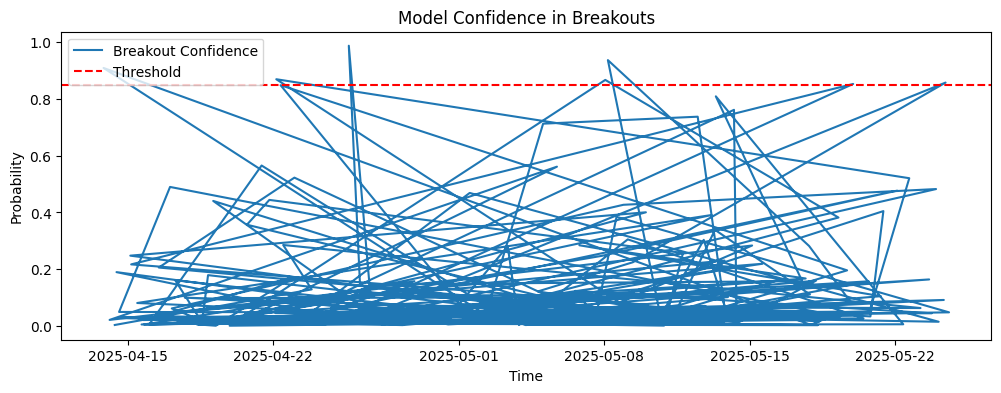


Top breakout hints:
                     candle_body_pct  candle_wick_top  candle_wick_bottom  \
open_time                                                                   
2025-04-25 16:00:00         0.266071           151.16              329.16   
2025-05-08 04:00:00        -0.434825           254.00               16.34   
2025-04-13 20:00:00        -0.379759           452.86              336.00   
2025-04-22 04:00:00        -0.319629           205.06               12.06   
2025-05-08 01:00:00         0.067312           556.58              153.41   
2025-05-24 11:00:00         0.249467           288.51               28.14   
2025-05-20 00:00:00         0.137572           847.05               18.00   

                     volatility       ATR14  breakout_prob  \
open_time                                                    
2025-04-25 16:00:00    0.004394  610.827143       0.987520   
2025-05-08 04:00:00    0.004390  663.570000       0.936791   
2025-04-13 20:00:00    0.005116  685.

In [ ]:
# 1. Imports
import pandas as pd
import requests
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

# 2. Fetch OHLCV data from Binance
url = "https://api.binance.com/api/v3/uiKlines"
params = {
    "symbol": "BTCUSDC",
    "interval": "1h",
    "limit": 1000
}
response = requests.get(url, params=params)
data = response.json()


# --- 2. Convert to DataFrame ---
df = pd.DataFrame(data, columns=[
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "num_trades",
    "taker_buy_base_vol", "taker_buy_quote_vol", "ignore"
])

# --- 3. Preprocessing ---
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
df = df.sort_values("open_time")

# Convert necessary columns to float
df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

# --- 4. Feature Engineering ---
df["candle_body"] = df["close"] - df["open"]
df["candle_range"] = df["high"] - df["low"]
df["candle_body_pct"] = df["candle_body"] / df["candle_range"]
df["candle_wick_top"] = df["high"] - df[["close", "open"]].max(axis=1)
df["candle_wick_bottom"] = df[["close", "open"]].min(axis=1) - df["low"]
df["return"] = df["close"].pct_change()
df["volatility"] = df["return"].rolling(window=14).std()

# ATR approximation
df["HL"] = df["high"] - df["low"]
df["HC"] = abs(df["high"] - df["close"].shift())
df["LC"] = abs(df["low"] - df["close"].shift())
df["TR"] = df[["HL", "HC", "LC"]].max(axis=1)
df["ATR14"] = df["TR"].rolling(window=14).mean()

# --- 5. Label Creation: 1 = breakout (>3% move up), 0 = no breakout ---
df["future_close"] = df["close"].shift(-3)
df["future_return"] = (df["future_close"] - df["close"]) / df["close"]
df["label"] = (df["future_return"] > 0.005).astype(int)

# --- 6. Drop NaNs and select features ---
df.dropna(inplace=True)
df.set_index("open_time", inplace=True)


features = [
    "candle_body_pct", "candle_wick_top", "candle_wick_bottom",
    "volatility", "ATR14"
]
X = df[features]
y = df["label"].astype(int)  # Ensure integer 0/1 labels

# Find indices where label == 1
one_indices = y[y == 1].index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("X_train", X_train)
print("y_train", y_train)
# --- 8. Train XGBoost Model ---
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# --- 9. Predict probabilities ---
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1 (breakout)
threshold = 0.85
high_confidence = y_proba > threshold

# --- 10. Annotate test set ---
X_test = X_test.copy()
X_test["breakout_prob"] = y_proba
X_test["predicted_breakout"] = (high_confidence).astype(int)
X_test["true_label"] = y_test.values

# --- 11. Evaluation ---
print(classification_report(y_test, X_test["predicted_breakout"]))

# Evaluate precision to adjust threshold

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision/Recall vs Threshold")

# --- 12. Plot Confidence Scores ---
plt.figure(figsize=(12, 4))
plt.plot(X_test["open_time"], y_proba)
plt.plot(X_test.index, y_proba, label="Breakout Confidence")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.title("Model Confidence in Breakouts")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()

# Optional: Review top confident breakouts
high_conf_df = X_test[X_test["predicted_breakout"] == 1]
print("\nTop breakout hints:")
print(high_conf_df.sort_values("breakout_prob", ascending=False).head(10))

plt.hist(y_proba, bins=100)
plt.title("Probability Distribution")
plt.xlabel("Breakout Probability")
plt.ylabel("Frequency")


# Combined multiple generalized model with real crypto symbols (212 atw)

In [ ]:
import pandas as pd
import requests
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import sleep


def fetch_symbols():
    """Fetch symbols from Binance API."""
    url = "https://api.terminal.binbot.in/symbols"
    response = requests.get(url)
    if not response.ok:
        raise Exception("Failed to fetch symbols from Binance")
    data = response.json()
    return [s["id"] for s in data["data"] if s["active"]]


# --- Settings ---
symbols = fetch_symbols()  # Expand this to 200
interval = "1h"
limit = 1000
breakout_threshold = 0.01  # 1% threshold
future_shift = 3

# --- Accumulators ---
X_all = []
y_all = []


# --- Feature extraction function ---
def process_symbol(symbol):
    url = "https://api.binance.com/api/v3/uiKlines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    r = requests.get(url, params=params)
    if not r.ok:
        print(f"Failed to fetch {symbol}")
        return None, None
    data = r.json()
    if not data or len(data) < future_shift + 1:
        return None, None

    df = pd.DataFrame(
        data,
        columns=[
            "open_time",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_asset_volume",
            "num_trades",
            "taker_buy_base_vol",
            "taker_buy_quote_vol",
            "ignore",
        ],
    )

    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df = df.sort_values("open_time")
    df[["open", "high", "low", "close", "volume"]] = df[
        ["open", "high", "low", "close", "volume"]
    ].astype(float)

    # Feature engineering
    df["candle_body"] = df["close"] - df["open"]
    df["candle_range"] = df["high"] - df["low"]
    df["candle_body_pct"] = df["candle_body"] / df["candle_range"].replace(0, np.nan)
    df["candle_wick_top"] = df["high"] - df[["close", "open"]].max(axis=1)
    df["candle_wick_bottom"] = df[["close", "open"]].min(axis=1) - df["low"]
    df["return"] = df["close"].pct_change()
    df["volatility"] = df["return"].rolling(window=14).std()

    df["HL"] = df["high"] - df["low"]
    df["HC"] = abs(df["high"] - df["close"].shift())
    df["LC"] = abs(df["low"] - df["close"].shift())
    df["TR"] = df[["HL", "HC", "LC"]].max(axis=1)
    df["ATR14"] = df["TR"].rolling(window=14).mean()

    df["future_close"] = df["close"].shift(-future_shift)
    df["future_return"] = (df["future_close"] - df["close"]) / df["close"]
    df["label"] = (df["future_return"] > breakout_threshold).astype(int)

    df.dropna(inplace=True)

    features = [
        "candle_body_pct",
        "candle_wick_top",
        "candle_wick_bottom",
        "volatility",
        "ATR14",
    ]

    X = df[features]
    y = df["label"].astype(int)

    return X, y


# --- Process all symbols ---
for symbol in tqdm(symbols):
    X, y = process_symbol(symbol)
    # Avoid rate limiting
    sleep(1)
    if X is not None and y is not None and y.sum() > 0:
        X_all.append(X)
        y_all.append(y)

# --- Concatenate all datasets ---
X_combined = pd.concat(X_all, axis=0)
y_combined = pd.concat(y_all, axis=0)

print("Combined label distribution:")
print(y_combined.value_counts())

# --- Split chronologically ---
split_idx = int(len(X_combined) * 0.8)
X_train, X_test = X_combined.iloc[:split_idx], X_combined.iloc[split_idx:]
y_train, y_test = y_combined.iloc[:split_idx], y_combined.iloc[split_idx:]

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# --- Train model ---
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# --- Predict ---
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.85
X_test = X_test.copy()
X_test["breakout_prob"] = y_proba
X_test["predicted_breakout"] = (y_proba > threshold).astype(int)
X_test["true_label"] = y_test.values

print("\nClassification Report:")
print(classification_report(y_test, X_test["predicted_breakout"]))

# --- Plot ---
plt.figure(figsize=(14, 5))
plt.plot(X_test.index, X_test["breakout_prob"], label="Breakout Confidence")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Model Confidence in Breakouts (All Symbols Combined)")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

 11%|█▏        | 24/212 [00:32<04:26,  1.42s/it]